# Machine Learning -  Multi-class Classification with Imbalanced Data-set

In [33]:
import pandas as pd
import numpy as np
import pickle
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
# For reproducibility
np.random.seed(1237)

In [34]:
# Source file directory
# downlaod from http://qwone.com/~jason/20Newsgroups/

path_train = "20news-bydate/20news-bydate-train"

files_train = skds.load_files(path_train,load_content=False)

label_index = files_train.target
label_names = files_train.target_names
labelled_files = files_train.filenames

data_tags = ["filename","category","news"]
data_list = []

# Read and add data from file to a list
i=0
for f in labelled_files:
    data_list.append((f,label_names[label_index[i]],Path(f).read_text()))
    i += 1

# We have training data available as dictionary filename, category, data
data = pd.DataFrame.from_records(data_list, columns=data_tags)

# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data) * .8)

train_posts = data['news'][:train_size]
train_tags = data['category'][:train_size]
train_files_names = data['filename'][:train_size]

test_posts = data['news'][train_size:]
test_tags = data['category'][train_size:]
test_files_names = data['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_posts, mode='tfidf')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [35]:
#crate class imbalance; my rough approach
data_imb = data.copy()

for i in range(1,6):
    for index, row in data_imb.iterrows():
        if((row["category"] == "alt.atheism"   or row["category"] == "talk.politics.misc" 
            or row["category"] =="soc.religion.christian" or row["category"] == "talk.politics.mideast")and (index % 3) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "comp.os.ms-windows.misc"  or row["category"] == "comp.sys.ibm.pc.hardware" or row["category"] == "comp.graphics" 
            or row["category"] =="comp.windows.x" or row["category"] == "comp.sys.mac.hardware")and (index % 4) == 0):
            data_imb.drop(index, inplace=True)
        elif((row["category"] == "sci.med"  or row["category"] == "sci.space" or row["category"] == "sci.electronics" 
            or row["category"] =="sci.crypt" or row["category"] == "misc.forsale") and (index % 5) == 0):
            data_imb.drop(index, inplace=True)

    data_imb.reset_index(drop = True, inplace=True)

In [36]:
data_imb.category.value_counts()

rec.sport.hockey            600
rec.motorcycles             598
rec.sport.baseball          597
rec.autos                   594
talk.politics.guns          546
talk.religion.misc          377
sci.med                     207
sci.electronics             205
sci.space                   197
sci.crypt                   183
misc.forsale                171
comp.os.ms-windows.misc     151
comp.graphics               146
comp.sys.ibm.pc.hardware    137
comp.windows.x              136
comp.sys.mac.hardware       131
soc.religion.christian       86
talk.politics.mideast        67
alt.atheism                  63
talk.politics.misc           55
Name: category, dtype: int64

In [37]:
class_labels = data_imb.category.tolist()

In [38]:
data_imb.head()

,filename,category,news
0,20news-bydate/20news-bydate-train\rec.sport.ba...,rec.sport.baseball,From: cubbie@garnet.berkeley.edu ( ...
1,20news-bydate/20news-bydate-train\comp.sys.mac...,comp.sys.mac.hardware,From: gnelson@pion.rutgers.edu (Gregory Nelson...
2,20news-bydate/20news-bydate-train\sci.crypt\15246,sci.crypt,From: crypt-comments@math.ncsu.edu\nSubject: C...
3,20news-bydate/20news-bydate-train\comp.sys.mac...,comp.sys.mac.hardware,From: ()\nSubject: Re: Quadra SCSI Problems??...
4,20news-bydate/20news-bydate-train\alt.atheism\...,alt.atheism,From: keith@cco.caltech.edu (Keith Allan Schne...


In [111]:
# 20 news groups
num_labels = 20
vocab_size = 15000
batch_size = 100
num_epochs = 30

# lets take 80% data as training and remaining 20% for test.
train_size = int(len(data_imb) * .8)

train_posts = data_imb['news'][:train_size]
train_tags = data_imb['category'][:train_size]
train_files_names = data_imb['filename'][:train_size]

test_posts = data_imb['news'][train_size:]
test_tags = data_imb['category'][train_size:]
test_files_names = data_imb['filename'][train_size:]

# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_posts)

x_train = tokenizer.texts_to_matrix(train_posts)
x_test = tokenizer.texts_to_matrix(test_posts)

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [112]:
x_train.shape, y_train.shape

((4197, 15000), (4197, 20))

In [113]:
#let us build a basic model
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               7680512   
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
activation_17 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 20)                10260     
__________

In [114]:
num_epochs =10
batch_size = 128
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Train on 3357 samples, validate on 840 samples
Epoch 1/10
 - 6s - loss: 2.1494 - acc: 0.4242 - val_loss: 1.1093 - val_acc: 0.7298
Epoch 2/10
 - 2s - loss: 0.5979 - acc: 0.8642 - val_loss: 0.5704 - val_acc: 0.8429
Epoch 3/10
 - 2s - loss: 0.1353 - acc: 0.9762 - val_loss: 0.3956 - val_acc: 0.8798
Epoch 4/10
 - 2s - loss: 0.0333 - acc: 0.9973 - val_loss: 0.3606 - val_acc: 0.8976
Epoch 5/10
 - 2s - loss: 0.0112 - acc: 1.0000 - val_loss: 0.3540 - val_acc: 0.8952
Epoch 6/10
 - 2s - loss: 0.0064 - acc: 0.9997 - val_loss: 0.3522 - val_acc: 0.8893
Epoch 7/10
 - 2s - loss: 0.0035 - acc: 1.0000 - val_loss: 0.3509 - val_acc: 0.8905
Epoch 8/10
 - 2s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.3551 - val_acc: 0.8893
Epoch 9/10
 - 2s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.3525 - val_acc: 0.8893
Epoch 10/10
 - 2s - loss: 0.0017 - acc: 1.0000 - val_loss: 0.3600 - val_acc: 0.8857


In [ ]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

In [27]:
#another approach using GRU model, takes longer time
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()

tokenizer_obj.fit_on_texts(train_posts) 

# pad sequences
max_length = max([len(s.split()) for s in train_posts])

# define vocabulary size
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens =  tokenizer_obj.texts_to_sequences(train_posts)
X_test_tokens = tokenizer_obj.texts_to_sequences(test_posts)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

encoder = LabelBinarizer()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

In [31]:
#another approach using GRU model, takes longer time
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 100

print('Build model...')

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(num_labels, activation='softmax'))

# try using different optimizers and different optimizer configs
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...
Summary of the built model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 50)            3599550   
_________________________________________________________________
gru_6 (GRU)                  (None, 32)                7968      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
Total params: 3,608,178
Trainable params: 3,608,178
Non-trainable params: 0
_________________________________________________________________
None


Actual label:sci.med
Predicted label: sci.med
Actual label:sci.crypt
Predicted label: sci.crypt
Actual label:rec.motorcycles
Predicted label: rec.motorcycles
Actual label:comp.sys.mac.hardware
Predicted label: sci.electronics
Actual label:talk.politics.guns
Predicted label: talk.politics.guns
Actual label:soc.religion.christian
Predicted label: soc.religion.christian
Actual label:comp.graphics
Predicted label: comp.graphics
Actual label:rec.sport.baseball
Predicted label: rec.sport.baseball
Actual label:talk.politics.guns
Predicted label: talk.politics.guns
Actual label:rec.motorcycles
Predicted label: rec.motorcycles
Normalized confusion matrix


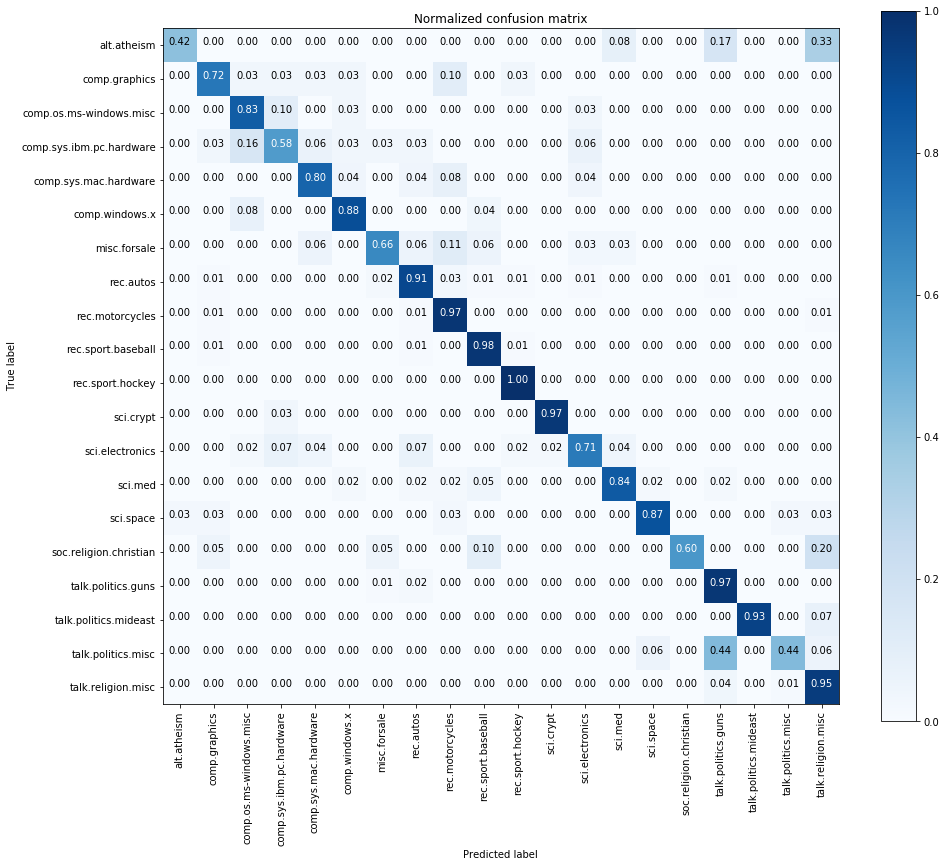

In [116]:
text_labels = encoder.classes_

for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    #print(test_files_names.iloc[i])
    print('Actual label:' + test_tags.iloc[i])
    print("Predicted label: " + predicted_label)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_pred = model.predict(x_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(14, 12, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')

fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)

In [117]:
prediction = model.predict(x_test)

In [118]:
predictions = np.argmax(prediction, axis = 1)

In [119]:
predictions

array([13, 11,  8, ...,  8,  2, 16], dtype=int64)

In [120]:
y_test_labels = np.argmax(y_test, axis =1)

In [121]:
y_test_labels

array([13, 11,  8, ...,  8,  5, 16], dtype=int64)

In [93]:
y_train_labels = np.argmax(y_train, axis =1)
y_train_labels

array([ 9,  4, 11, ...,  9, 14, 16], dtype=int64)

In [94]:
#The Kappa score tell you how much better, or worse, your classifier is than what would be expected by random chance. 
#If you were to randomly assign cases to classes (i.e. a kind of terribly uninformed classifier), you'd get some correct simply by chance. 
#Therefore, you will always find that the Kappa value is lower than the overall accuracy. 
#The Kappa index is however considered to be a more conservative measure than the overall classification accuracy. 
#Your KIA value is telling you essentially that your classifier is about 66% better than a random assignment of cases to the various classes. That's not bad!
#A kappa value of 1 represents perfect agreement, while a value of 0 represents no agreement.

from sklearn.metrics import cohen_kappa_score
cohen_score = cohen_kappa_score(y_test_labels, predictions)

In [175]:
cohen_score

0.8570501222325042

In [55]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(y_test_labels, predictions)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.75       0.66666667 0.75       0.68965517 0.7037037  0.82142857
 0.9        0.89719626 0.890625   0.94308943 0.97637795 0.96774194
 0.88235294 0.92105263 0.875      1.         0.87826087 1.
 0.76923077 0.91463415]
recall: [0.5        0.75862069 0.82758621 0.64516129 0.76       0.88461538
 0.77142857 0.88888889 0.97435897 0.95867769 1.         0.96774194
 0.66666667 0.81395349 0.92105263 0.65       0.98058252 0.85714286
 0.55555556 0.92592593]
fscore: [0.6        0.70967742 0.78688525 0.66666667 0.73076923 0.85185185
 0.83076923 0.89302326 0.93061224 0.95081967 0.98804781 0.96774194
 0.75949367 0.86419753 0.8974359  0.78787879 0.9266055  0.92307692
 0.64516129 0.9202454 ]
support: [ 12  29  29  31  25  26  35 108 117 121 124  31  45  43  38  20 103  14
  18  81]


In [58]:
from sklearn.metrics import confusion_matrix
import numpy as np


cm = confusion_matrix(y_test_labels, predictions)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

print(recall)

print(precision)

[0.5        0.75862069 0.82758621 0.64516129 0.76       0.88461538
 0.77142857 0.88888889 0.97435897 0.95867769 1.         0.96774194
 0.66666667 0.81395349 0.92105263 0.65       0.98058252 0.85714286
 0.55555556 0.92592593]
[0.75       0.66666667 0.75       0.68965517 0.7037037  0.82142857
 0.9        0.89719626 0.890625   0.94308943 0.97637795 0.96774194
 0.88235294 0.92105263 0.875      1.         0.87826087 1.
 0.76923077 0.91463415]


In [ ]:
#Let us try some sampling technique to remove class imbalance
from imblearn.over_sampling import SMOTE
#Over-sampling: SMOTE
#SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, 
#based on those that already exist. It works randomly picking a point from the minority class and computing 
#the k-nearest neighbors for this point.The synthetic points are added between the chosen point and its neighbors.
#We'll use ratio='minority' to resample the minority class.
smote = SMOTE('minority')

X_sm, y_sm = smote.fit_sample(x_train, y_train)
print(X_sm.shape, y_sm.shape)

In [126]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight('balanced' ,np.unique(y_train_labels) ,y_train_labels)
num_epochs =10
batch_size = 128
history = model.fit(X_sm, y_sm,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    class_weight=class_weight,
                    validation_split=0.2)

Train on 3716 samples, validate on 930 samples
Epoch 1/10
 - 10s - loss: 0.0593 - acc: 0.9839 - val_loss: 0.2841 - val_acc: 0.9075
Epoch 2/10
 - 2s - loss: 0.0138 - acc: 0.9995 - val_loss: 0.1916 - val_acc: 0.9441
Epoch 3/10
 - 3s - loss: 0.0068 - acc: 0.9997 - val_loss: 0.1903 - val_acc: 0.9387
Epoch 4/10
 - 3s - loss: 0.0057 - acc: 0.9997 - val_loss: 0.1924 - val_acc: 0.9376
Epoch 5/10
 - 2s - loss: 0.0054 - acc: 0.9997 - val_loss: 0.1889 - val_acc: 0.9452
Epoch 6/10
 - 2s - loss: 0.0051 - acc: 0.9997 - val_loss: 0.1899 - val_acc: 0.9430
Epoch 7/10
 - 3s - loss: 0.0050 - acc: 0.9997 - val_loss: 0.1897 - val_acc: 0.9419
Epoch 8/10
 - 2s - loss: 0.0048 - acc: 0.9997 - val_loss: 0.1889 - val_acc: 0.9409
Epoch 9/10
 - 2s - loss: 0.0047 - acc: 0.9997 - val_loss: 0.1900 - val_acc: 0.9398
Epoch 10/10
 - 2s - loss: 0.0047 - acc: 0.9997 - val_loss: 0.1889 - val_acc: 0.9409


In [127]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)

Test accuracy: 0.8904761907032558


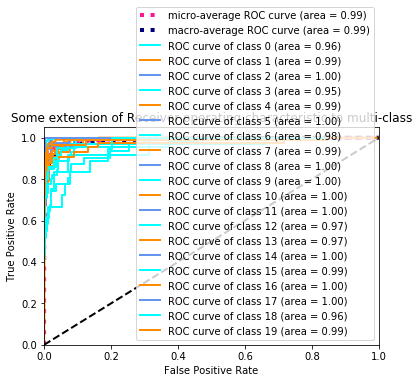

In [128]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_labels):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_labels)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_labels):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_labels

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_labels), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [129]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_labels):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        prediction[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], prediction[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    prediction.ravel())
average_precision["micro"] = average_precision_score(y_test, prediction,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.94


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.94')

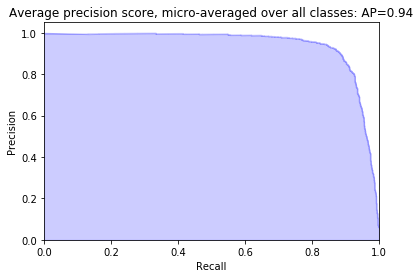

In [130]:
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')#,
                 #**step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

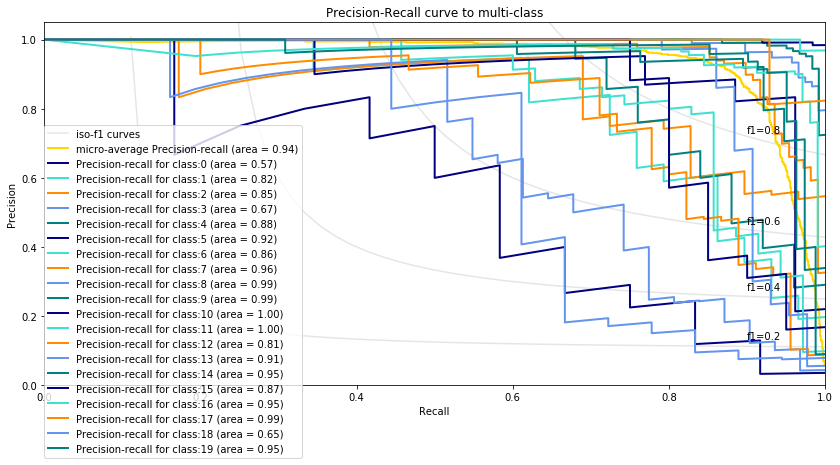

In [131]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(14, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(num_labels), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class:{0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.2), prop=dict(size=10))


plt.show()